In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

savedir = "models/prior-posterior"
os.makedirs(savedir, exist_ok=True)

In [12]:
# def get_conjugate_gaussians(
#         prior_mu=0.0,
#         prior_sigma=1.0,
#         ll_mu=0.0,
#         ll_sigma=1.0,
# ):
#     prior = torch.distributions.Normal(loc=prior_mu, scale=prior_sigma)
#     mu = (prior_mu * prior_sigma ** -2) + (ll_mu * ll_sigma ** -2)
#     mu /= (prior_sigma ** -2 + ll_sigma ** -2)
#     var = (prior_sigma **2 * ll_sigma ** 2) / (prior_sigma **2 + ll_sigma ** 2)
#     posterior = torch.distributions.Normal(loc=mu, scale=np.sqrt(var))
#     return prior, posterior

In [2]:
# %%time
sigma = 0.1
dim = 1
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)

prior, posterior = get_conjugate_gaussians(
    prior_mu=0.0,
    prior_sigma=1.0,
    ll_mu=3.0,
    ll_sigma=1.0,
)
print(posterior.loc, posterior.scale)

start = time.time()
for k in range(1000):
    optimizer.zero_grad()

    x0 = prior.sample((batch_size, 1))
    x1 = posterior.sample((batch_size, 1))

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    # if (k + 1) % 100 == 0:
    if (k + 1) in (10, 300, 1000):
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        if (showresults := False):
            with torch.no_grad():
                traj = node.trajectory(
                    prior.sample((500, 1)),
                    t_span=torch.linspace(0, 1, 100),
                )
                # traj.shape = [100, 1024, dim]
                plot_trajectories_1d(
                    traj.cpu().numpy(),
                    prior, posterior)

torch.save(model, f"{savedir}/cfm_v1.pt")

tensor(1.5000) tensor(0.7071)
10: loss 1.702 time 0.05
300: loss 1.112 time 0.79
1000: loss 1.181 time 1.99


## Checking invariance

Here, we show that a model trained with one prior does not generalise to 
another prior with the same likelihood.

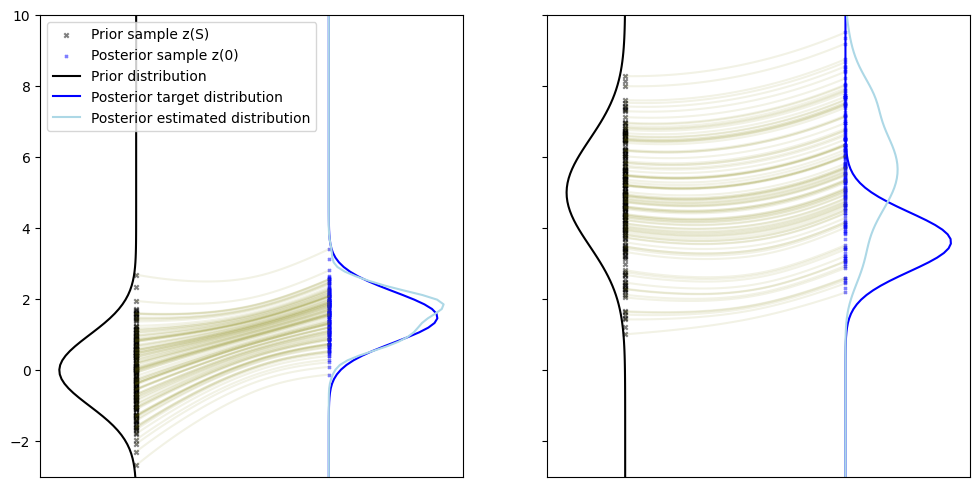

In [3]:

fig, axs = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
mus = (0.0, 5.0)
sigmas = (1.0, 1.5)


model = torch.load(f"{savedir}/cfm_v1.pt")

for (m, s, ax) in zip(mus, sigmas, axs):

    prior, posterior = get_conjugate_gaussians(
        prior_mu=m,
        prior_sigma=s,
        ll_mu=3.0,
        ll_sigma=1.0,
    )

    node = NeuralODE(
        torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )

    with torch.no_grad():
        traj = node.trajectory(
            prior.sample((200, 1)),
            t_span=torch.linspace(0, 1, 100),
        )
        # traj.shape = [100, 1024, dim]
        _ = plot_trajectories_1d(
            traj.cpu().numpy(),
            prior, posterior,
            fig, ax
        )
    ax.set_ylim([-3, 10])
    ax.set_title(f"$\mu_0={m}, \sigma_0={s}$")
    
axs[0].legend()
fig.savefig(f"{savedir}/dist_mismatch.pdf")

## Optimal flow

tensor(3.) tensor(0.7071)
10: loss 0.327 time 0.13
300: loss 0.019 time 4.03
1000: loss 0.012 time 8.51


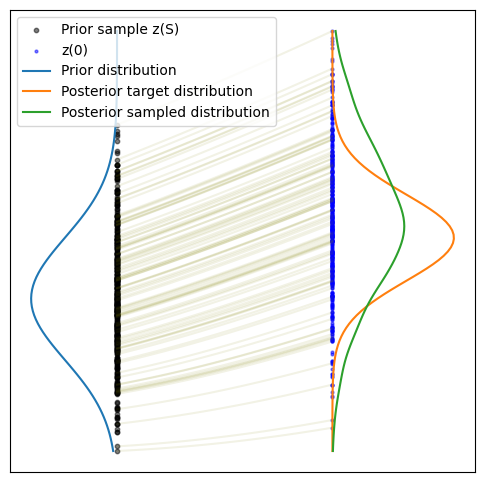

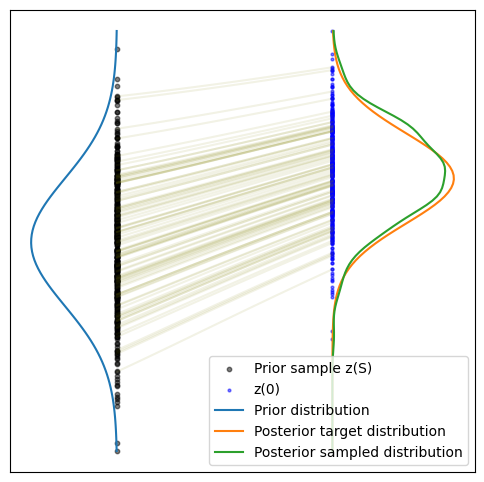

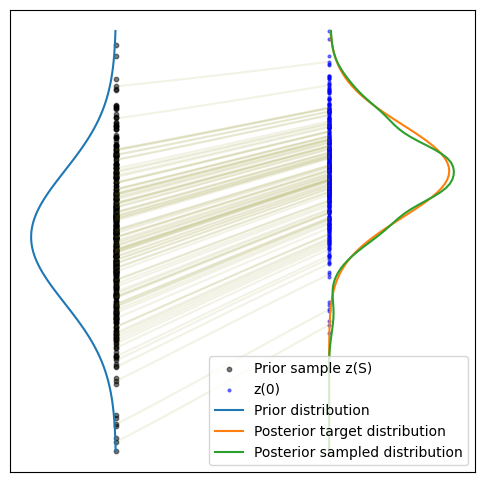

In [17]:
# %%time
sigma = 0.1
dim = 1
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

prior, posterior = get_conjugate_gaussians(
    prior_mu=2.0,
    prior_sigma=1.0,
    ll_mu=4.0,
    ll_sigma=1.0,
)
print(posterior.loc, posterior.scale)

start = time.time()
for k in range(1000):
    optimizer.zero_grad()

    x0 = prior.sample((batch_size, 1))
    x1 = posterior.sample((batch_size, 1))

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    # if (k + 1) % 100 == 0:
    if (k + 1) in (10, 300, 1000):
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                prior.sample((500, 1)),
                t_span=torch.linspace(0, 1, 100),
            )
            # traj.shape = [100, 1024, dim]
            plot_trajectories_1d(
                traj.cpu().numpy(),
                prior, posterior)

torch.save(model, f"{savedir}/cfm_ot_v1.pt")

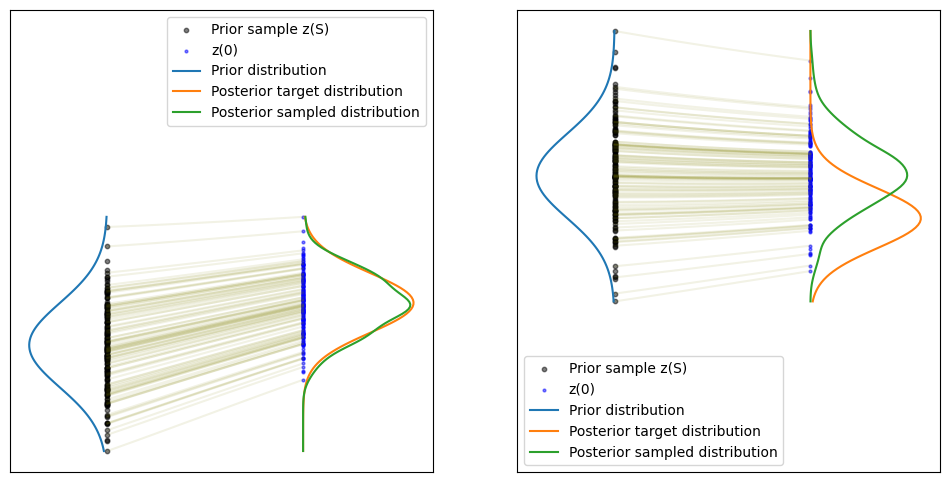

In [18]:

fig, axs = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
shifts = np.linspace(0, 4, axs.size)

model = torch.load(f"{savedir}/cfm_ot_v1.pt")

for (shift, ax) in zip(shifts, axs):

    prior, posterior = get_conjugate_gaussians(
        prior_mu=2.0 + shift,
        prior_sigma=1.0,
        ll_mu=4.0,
        ll_sigma=1.0,
    )

    node = NeuralODE(
        torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )

    with torch.no_grad():
        traj = node.trajectory(
            prior.sample((200, 1)),
            t_span=torch.linspace(0, 1, 100),
        )
        # traj.shape = [100, 1024, dim]
        _ = plot_trajectories_1d(
            traj.cpu().numpy(),
            prior, posterior,
            fig, ax
        )
    
    
fig.savefig(f"{savedir}/dist_mismatch.pdf")